In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# visualize 
import matplotlib.pyplot as plt

# for tsa
import statsmodels.api as sm
import itertools as it

from fbprophet import Prophet

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w
import model as m

Importing plotly failed. Interactive plots will not work.


In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
#Acquire superstore data from codeup database
df = w.get_superstore_data()

In [4]:
#Cleaning superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [5]:
#Does one or another stand out in terms of sales volume? 

In [6]:
#What does sales look like over time?

<AxesSubplot:xlabel='Order Date'>

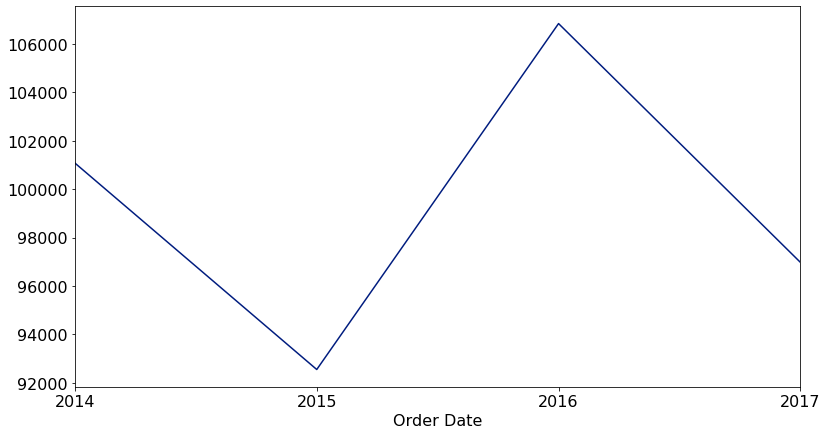

In [7]:
#Look at the total sales over the years
df.resample('Y').sales.sum().plot()

<AxesSubplot:xlabel='Order Date'>

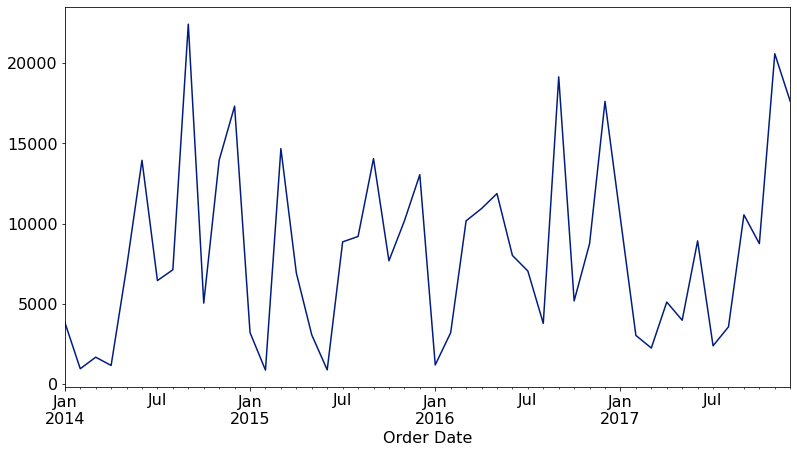

In [8]:
#Look at the total sales for every month
df.resample('M').sales.sum().plot()

In [9]:
#Split data
train, validate, test = w.split_time_series_data(df)

Text(0, 0.5, 'Total Sales')

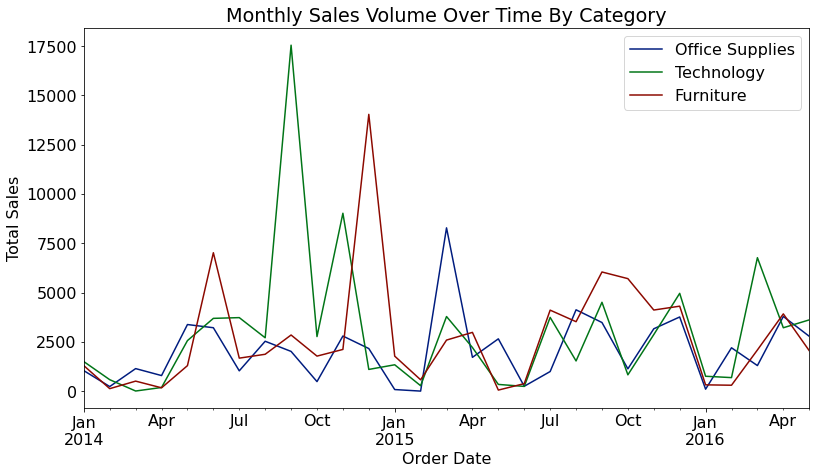

In [10]:
#Better graph
for c in train.category.unique():
    sample = train[train.category == c]
    sample.resample('M').sales.sum().plot(label=c)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Category")
plt.ylabel("Total Sales")

Text(0, 0.5, 'Total Sales')

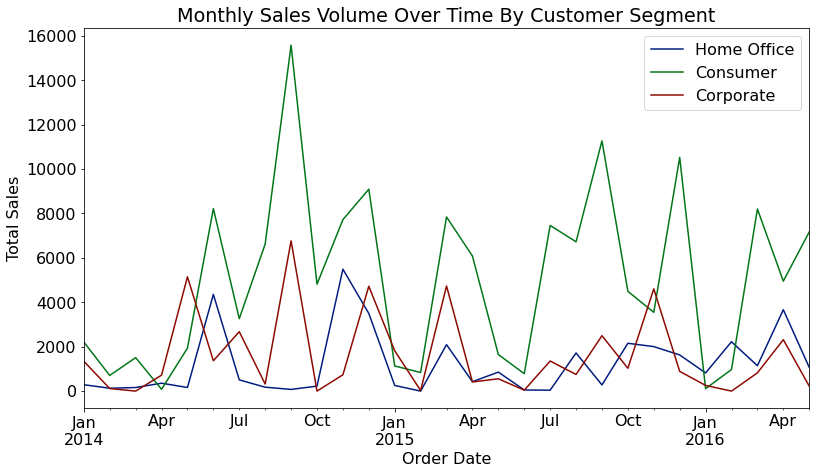

In [11]:
for s in train.segment.unique():
    sample = train[train.segment == s]
    sample.resample('M').sales.sum().plot(label=s)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Customer Segment")
plt.ylabel("Total Sales")

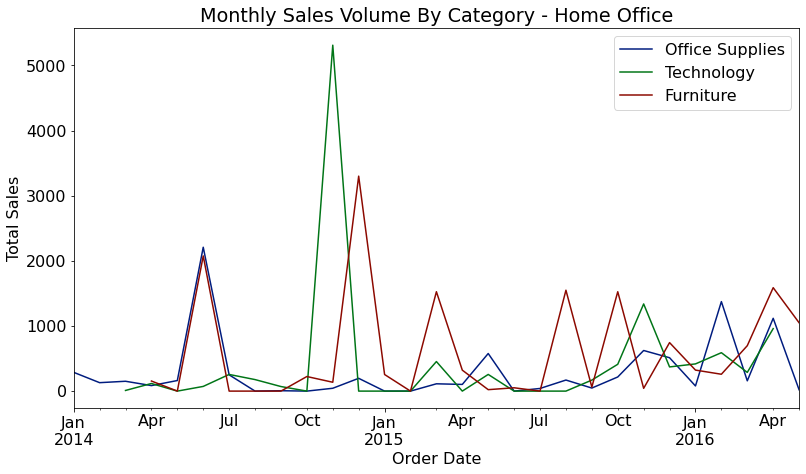

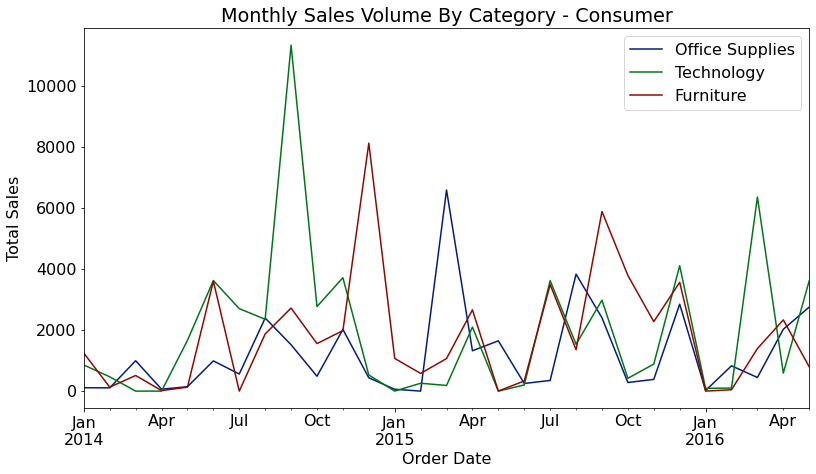

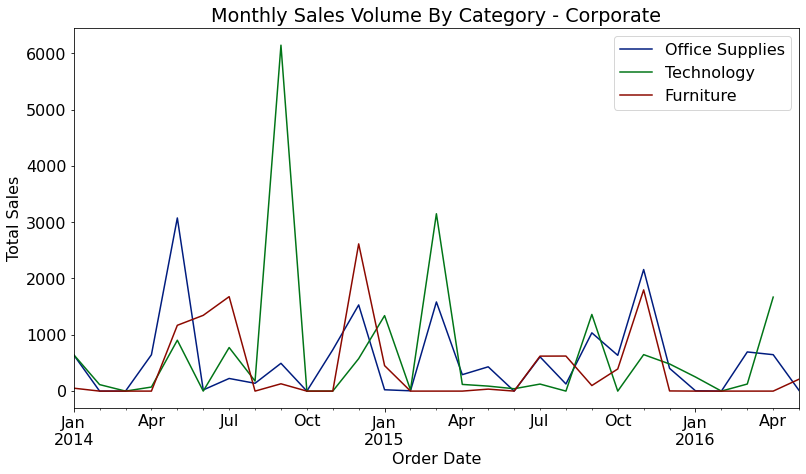

In [12]:
# Plot sales volume by category - different plot for each segment
for s in train.segment.unique():
    for c in train.category.unique():
        sample = train[(train.category == c)&(train.segment == s)]
        sample.resample('M').sales.sum().plot(label=c)
        plt.legend()
    plt.title(f"Monthly Sales Volume By Category - {s}")
    plt.ylabel("Total Sales")
    plt.show()

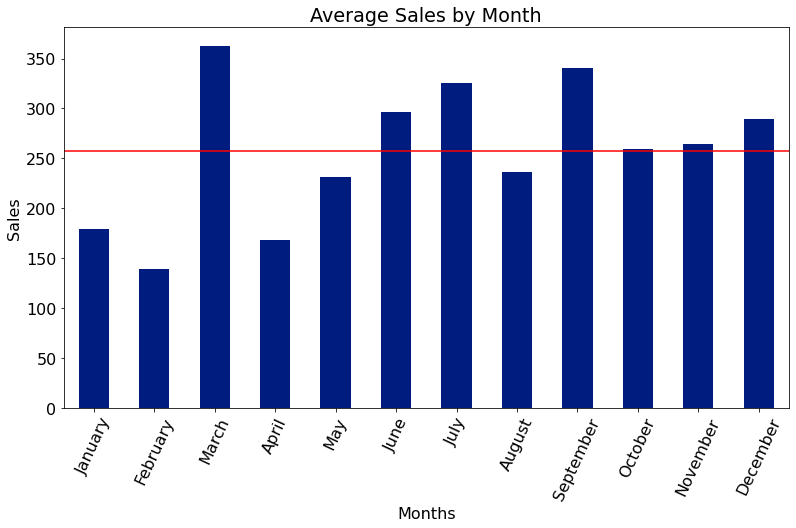

In [13]:
#What our average sales look like for each month?
train['month'] = pd.Categorical(train['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
overall_mean = train.groupby('month').sales.mean().mean()
train.groupby('month').sales.mean().plot.bar()
plt.title("Average Sales by Month")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.tick_params('x', rotation=65)
plt.axhline(overall_mean,color="r")

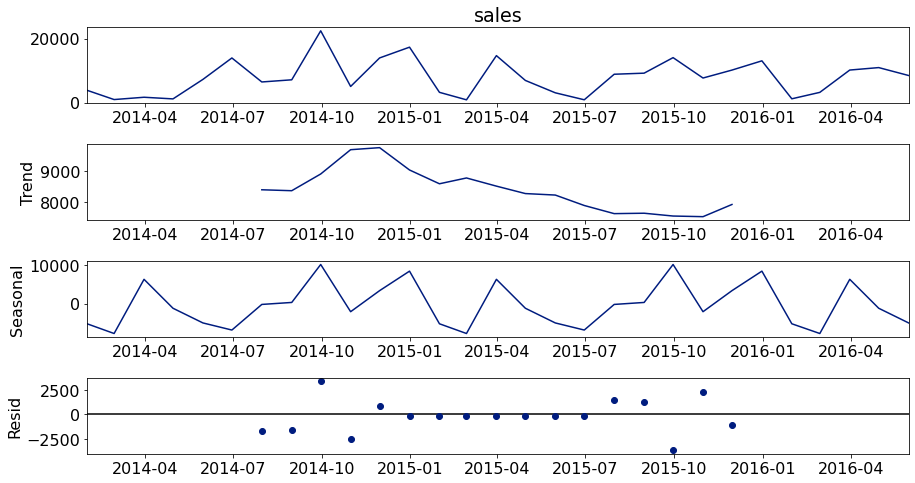

In [14]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
y = train.resample('M').sales.sum()
sm.tsa.seasonal_decompose(y).plot()
None

#### Overall takeaway:

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. In addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales. Technology is high across all 3 segments

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

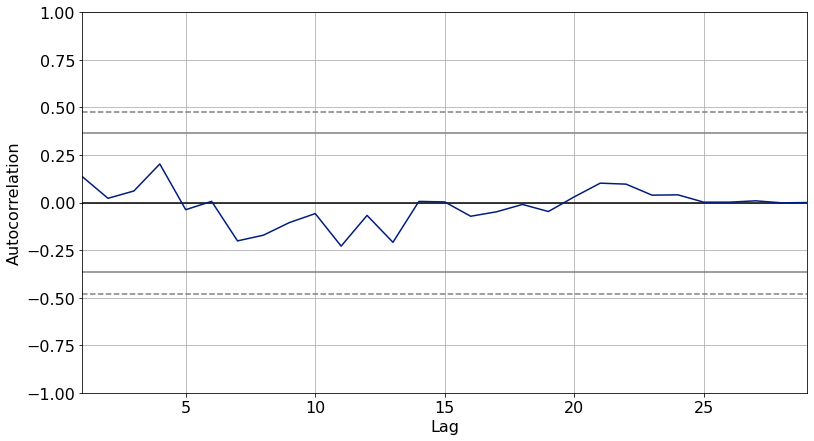

In [15]:
#auto correlation
pd.plotting.autocorrelation_plot(train.sales.resample('M').mean())

Easier to tell trends when sampled over longer period of time

In [16]:
#Modeling
#We will prophet for model because
#Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
#It works best with time series that have strong seasonal effects and several seasons of historical data. 
#Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [17]:
#Segments and Category
for s in train.segment.unique():
    for c in train.category.unique():
        sample = train[(train.category == c)&(train.segment == s)]

In [18]:
sample = sample[['sales']]

In [19]:
sample = sample.sort_values('Order Date')
sample = sample.groupby('Order Date')['sales'].sum().reset_index()
sample = sample.set_index('Order Date')
sample.head()

,sales
Order Date,
2014-01-10,51.940
2014-05-14,310.880
2014-05-26,290.666
2014-05-27,567.120
2014-06-15,897.862


In [20]:
monthly_sample = sample['sales'].resample('M').mean()
sample = pd.DataFrame({'Order Date':monthly_sample.index, 'Sales':monthly_sample.values})

In [21]:
sample = sample.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
sample_model = Prophet(interval_width=0.95)
sample_model.fit(sample)

sample_forecast = sample_model.make_future_dataframe(periods = 36, freq = 'MS')
sample_forecast = sample_model.predict(sample_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -61.5698
Iteration  1. Log joint probability =     6.9221. Improved by 68.4919.
Iteration  2. Log joint probability =    20.5967. Improved by 13.6747.
Iteration  3. Log joint probability =    30.1104. Improved by 9.51363.
Iteration  4. Log joint probability =    41.5664. Improved by 11.456.
Iteration  5. Log joint probability =     48.118. Improved by 6.55164.
Iteration  6. Log joint probability =    63.8399. Improved by 15.7219.
Iteration  7. Log joint probability =    74.7897. Improved by 10.9498.
Iteration  8. Log joint probability =    85.3163. Improved by 10.5266.
Iteration  9. Log joint probability =    95.1964. Improved by 9.88006.
Iteration 10. Log joint probability =    112.525. Improved by 17.3285.
Iteration 11. Log joint probability =    113.258. Improved by 0.733429.
Iteration 12. Log joint probability =    134.171. Improved by 20.9123.
Iteration 13. Log joint probability =    134.266. Improved by 0.0954733.
Iteration 14. Log joint probabili

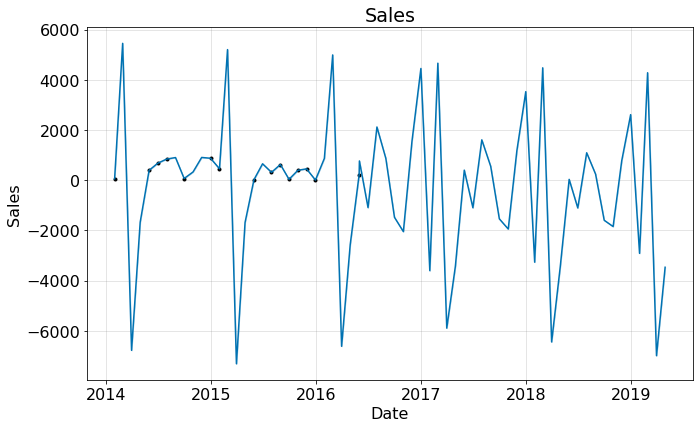

In [22]:
sample_model.plot(sample_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales')
plt.show()

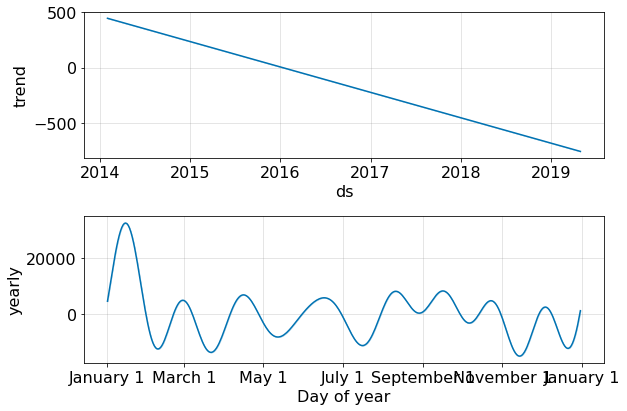

In [23]:
sample_model.plot_components(sample_forecast)
plt.show()

In [24]:
#Extract the data of Office Supplies, technology and furniture
office_supplies = train.loc[train['category'] == 'Office Supplies']
furniture = train.loc[train['category'] == 'Furniture']
technology = train.loc[train['category'] == 'Technology']

In [25]:
office_supplies = office_supplies[['sales']]
furniture = furniture[['sales']]
technology = technology[['sales']]

In [26]:
office_supplies = office_supplies.sort_values('Order Date')
office_supplies = office_supplies.groupby('Order Date')['sales'].sum().reset_index()
office_supplies = office_supplies.set_index('Order Date')
office_supplies.head()

,sales
Order Date,
2014-01-04,288.060
2014-01-09,9.344
2014-01-10,2.890
2014-01-13,640.520
2014-01-16,48.660


In [27]:
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.head()

,sales
Order Date,
2014-01-10,51.940
2014-01-11,9.940
2014-01-16,127.104
2014-01-20,1106.540
2014-02-12,129.568


In [28]:
technology = technology.sort_values('Order Date')
technology = technology.groupby('Order Date')['sales'].sum().reset_index()
technology = technology.set_index('Order Date')
technology.head()

,sales
Order Date,
2014-01-09,31.20
2014-01-13,646.74
2014-01-16,124.20
2014-01-20,699.93
2014-02-01,468.90


In [29]:
monthly_office = office_supplies['sales'].resample('M').mean()
monthly_furniture = furniture['sales'].resample('M').mean()
monthly_technology = technology['sales'].resample('M').mean()

In [30]:
furniture = pd.DataFrame({'Order Date':monthly_furniture.index, 'Sales':monthly_furniture.values})
office = pd.DataFrame({'Order Date': monthly_office.index, 'Sales': monthly_office.values})
technology = pd.DataFrame({'Order Date': monthly_technology.index, 'Sales': monthly_technology.values})

In [31]:
#Create model
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model1 = Prophet(interval_width = 0.95)
furniture_model1.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model1 = Prophet(interval_width=0.95)
office_model1.fit(office)

technology = technology.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_model1 = Prophet(interval_width=0.95)
technology_model1.fit(technology)

#Prophet has make_future_dataframe propterty that an argument periods (number of periods to forecast forward).
#Look into five years ahead
furniture_forecast = furniture_model1.make_future_dataframe(periods = 48, freq = 'MS')
furniture_forecast = furniture_model1.predict(furniture_forecast)

office_forecast = office_model1.make_future_dataframe(periods = 48, freq = 'MS')
office_forecast = office_model1.predict(office_forecast)

technology_forecast = technology_model1.make_future_dataframe(periods = 48, freq = 'MS')
technology_forecast = technology_model1.predict(technology_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -48.2986
Iteration  1. Log joint probability =    24.2289. Improved by 72.5275.
Iteration  2. Log joint probability =    41.8163. Improved by 17.5873.
Iteration  3. Log joint probability =    54.0278. Improved by 12.2115.
Iteration  4. Log joint probability =    55.0791. Improved by 1.05134.
Iteration  5. Log joint probability =    55.2738. Improved by 0.19473.
Iteration  6. Log joint probability =    55.2815. Improved by 0.00767737.
Iteration  7. Log joint probability =    55.3104. Improved by 0.0288299.
Iteration  8. Log joint probability =    55.3137. Improved by 0.0033459.
Iteration  9. Log joint probability =     55.372. Improved by 0.0583473.
Iteration 10. Log joint probability =     55.421. Improved by 0.0489721.
Iteration 11. Log joint probability =    55.4324. Improved by 0.0113712.
Iteration 12. Log joint probability =    55.5368. Improved by 0.104402.
Iteration 13. Log joint probability =    55.5599. Improved by 0.0230585.
Iteration 14. Log j

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


Iteration  1. Log joint probability =    25.6344. Improved by 73.8874.
Iteration  2. Log joint probability =    38.4735. Improved by 12.8392.
Iteration  3. Log joint probability =    55.1814. Improved by 16.7079.
Iteration  4. Log joint probability =    59.4543. Improved by 4.27293.
Iteration  5. Log joint probability =    59.4674. Improved by 0.0130418.
Iteration  6. Log joint probability =    59.6076. Improved by 0.14018.
Iteration  7. Log joint probability =    59.6171. Improved by 0.00953201.
Iteration  8. Log joint probability =    59.6604. Improved by 0.043332.
Iteration  9. Log joint probability =    59.6767. Improved by 0.0162784.
Iteration 10. Log joint probability =    59.6769. Improved by 0.000222325.
Iteration 11. Log joint probability =    59.6801. Improved by 0.00317522.
Iteration 12. Log joint probability =    59.6923. Improved by 0.01219.
Iteration 13. Log joint probability =    59.6938. Improved by 0.0014827.
Iteration 14. Log joint probability =    59.6965. Improved b

In [32]:
#Forecasting Furniture, Office Supplies and Technology Sales
#Black dot represent the train data and blue line is the forecast

In [33]:
#What our sales goal for the next 5 years?
#Based on forecasting of 3 categories what do future sales going to look like?

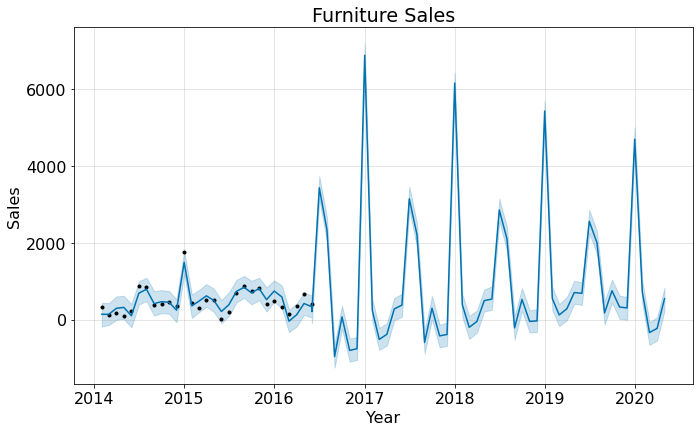

In [34]:
furniture_model1.plot(furniture_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

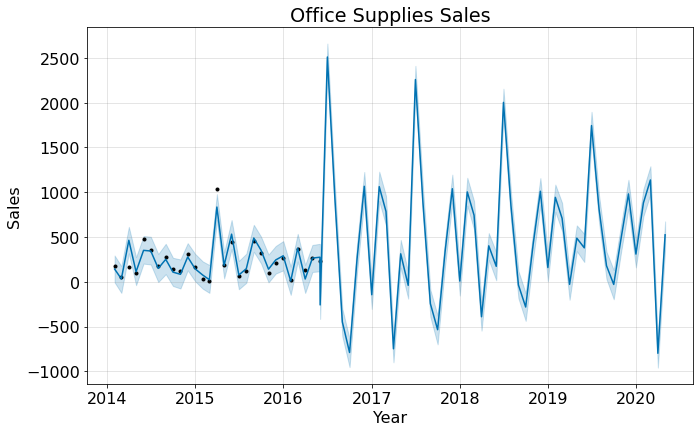

In [35]:
office_model1.plot(office_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Office Supplies Sales')
plt.show()

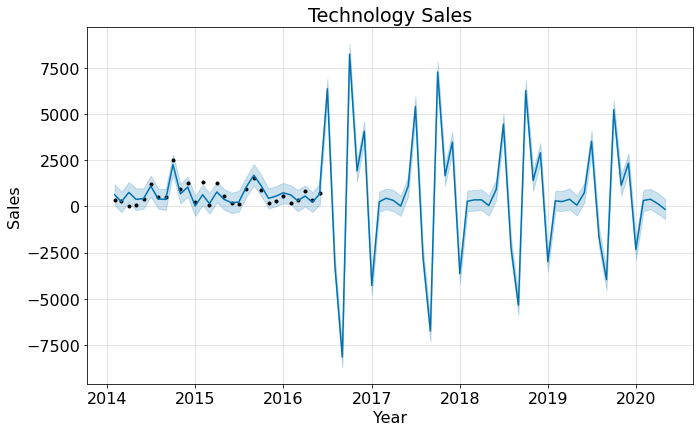

In [36]:
technology_model1.plot(technology_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Technology Sales')
plt.show()

In [37]:
furniture_model, office_model, technology_model, furniture_forecast, office_forecast, technology_forecast = m.create_model(train, 'category', 'Order Date', target = 'sales')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -48.2986
Iteration  1. Log joint probability =    24.2289. Improved by 72.5275.
Iteration  2. Log joint probability =    41.8163. Improved by 17.5873.
Iteration  3. Log joint probability =    54.0278. Improved by 12.2115.
Iteration  4. Log joint probability =    55.0791. Improved by 1.05134.
Iteration  5. Log joint probability =    55.2738. Improved by 0.19473.
Iteration  6. Log joint probability =    55.2815. Improved by 0.00767737.
Iteration  7. Log joint probability =    55.3104. Improved by 0.0288299.
Iteration  8. Log joint probability =    55.3137. Improved by 0.0033459.
Iteration  9. Log joint probability =     55.372. Improved by 0.0583473.
Iteration 10. Log joint probability =     55.421. Improved by 0.0489721.
Iteration 11. Log joint probability =    55.4324. Improved by 0.0113712.
Iteration 12. Log joint probability =    55.5368. Improved by 0.104402.
Iteration 13. Log joint probability =    55.5599. Improved by 0.0230585.
Iteration 14. Log j

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


Iteration  1. Log joint probability =    25.6344. Improved by 73.8874.
Iteration  2. Log joint probability =    38.4735. Improved by 12.8392.
Iteration  3. Log joint probability =    55.1814. Improved by 16.7079.
Iteration  4. Log joint probability =    59.4543. Improved by 4.27293.
Iteration  5. Log joint probability =    59.4674. Improved by 0.0130418.
Iteration  6. Log joint probability =    59.6076. Improved by 0.14018.
Iteration  7. Log joint probability =    59.6171. Improved by 0.00953201.
Iteration  8. Log joint probability =    59.6604. Improved by 0.043332.
Iteration  9. Log joint probability =    59.6767. Improved by 0.0162784.
Iteration 10. Log joint probability =    59.6769. Improved by 0.000222325.
Iteration 11. Log joint probability =    59.6801. Improved by 0.00317522.
Iteration 12. Log joint probability =    59.6923. Improved by 0.01219.
Iteration 13. Log joint probability =    59.6938. Improved by 0.0014827.
Iteration 14. Log joint probability =    59.6965. Improved b

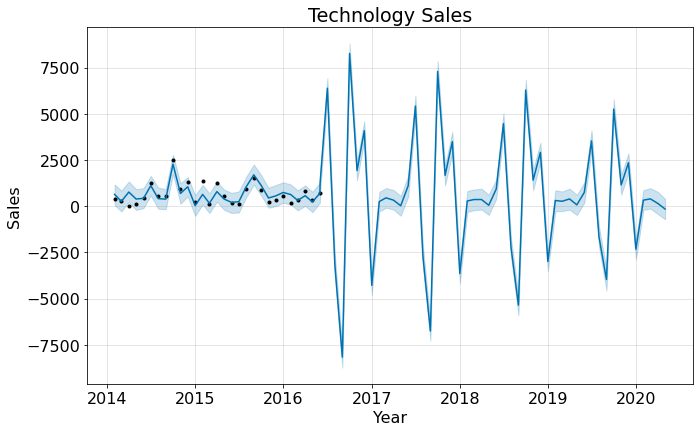

In [38]:
technology_model.plot(technology_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Technology Sales')
plt.show()

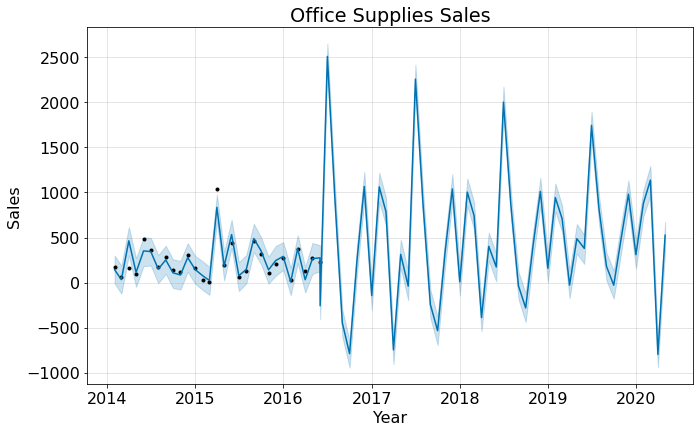

In [39]:
office_model.plot(office_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Office Supplies Sales')
plt.show()

Its good to see that the category increasing overtime and keep growing.